# 경주여행과 전주 여행에 대해 최빈 단어 시각화와 유사도 분석
1) 네이버 open API 활용하여 네이버지식인 "경주여행", "전주여행" 각각 500건씩 검색
    replace(), re.sum()이용
    백업파일 결과: 검색어, no, title, link, description, total_text(title+ ' ' + description)
2) 품사 태깅 백업(naver_pos.csv)
    * query, no, token, pos

3) 명사만 추출 백업 (naver_pos_nouns.csv)
    * query, token, pos

4) 빈도분석 백업(naver_pos_nouns_count.csv)
    *token, 경주빈도, 전주빈도, 빈도합
    
5) 빈도 시각화(워드클라우드, Text.plot)
    *워드클라우드 이미지 저장
  
6) 단어간 유사도 분석(word2Vec, 연관분석)

 naver open API를 활용하여 검색어 500건 추출
query,no,title,link,description,total_text(title+' '+description)

In [1]:
# .env 가져오기(방법1) - 추천
from dotenv import load_dotenv
import os
load_dotenv()
# print(os.getenv('CLIENT_ID'))
# print(os.getenv('CLIENT_SECRET'))

True

In [2]:
# .env 가져오기(방법2)
from decouple import config
# print(config('CLIENT_ID'))
# print(config('CLIENT_SECRET'))

In [3]:
# 네이버 검색 API 예제 - 블로그 검색
import os
import sys
import urllib.request
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')
encText = urllib.parse.quote("경주 여행")
url = "https://openapi.naver.com/v1/search/blog?query=" + encText # JSON 결과
# url = "https://openapi.naver.com/v1/search/blog.xml?query=" + encText # XML 결과
request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
response = urllib.request.urlopen(request)
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    print(response_body.decode('utf-8')[:200])
else:
    print("Error Code:" + rescode)

{
	"lastBuildDate":"Tue, 02 Dec 2025 16:36:26 +0900",
	"total":1003255,
	"start":1,
	"display":10,
	"items":[
		{
			"title":"내 마음대로 기록하는 <b>경주여행<\/b> 2박3일",
			"link":"https:\/\/blog.naver.com\/hello


In [4]:
# 방법1
import requests
import pandas as pd
import json # response텍스트를 json스타일의 딕셔너리로
import re  # 정규표현식
from html import unescape # description에 &lt;등의 특수문자를 <(문자)로 변경

client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')
query = '경주 여행'
start = 1
headers = {
    'X-Naver-Client-Id':client_id,
    'X-Naver-Client-Secret':client_secret
}
# url = f'https://openapi.naver.com/v1/search/kin?query={query}&display=100&start={start}'
# response = requests.get(url, headers=headers)
url = 'https://openapi.naver.com/v1/search/kin'
params = {'query':query, 'display':100, 'start':start}
response = requests.get(url, params=params, headers=headers)
# print(response.text[:500])
# items = json.loads(response.text)['items']
items = response.json()['items']
print(len(items))

100


In [5]:
# title, link, description 추출(b태그삭제, 특수문자조정(&gt; -> >), 정규표현식을 이용한 한글추출 )
item = items[97]
title = item.get('title').replace('<b>', '').replace('</b>', '')
link = item['link']
description = item.get('description').replace('<b>', '').replace('</b>', '')
# html 특수 문자 처리
description = unescape(description)
# 정규표현식 : 알파벳, 숫자, 한글만 남기고 나머지는 제거
description = re.sub(r'[^a-zA-Z0-9가-힣]', ' ', description)
description = re.sub('\s+', ' ', description)
print(title, link, description)

경주 여행지 추천 https://kin.naver.com/qna/detail.naver?d1id=9&dirId=90111&docId=261370795&qb=6rK97KO8IOyXrO2WiQ==&enc=utf8  2 부산을 벗어난 경주 여행지 알려주세요 3 당일치기로 경주 여행코스 밑에 자세하게 권역별로 여행코스를 소개했습니다 경주여행이 처음이라면 대릉원 첨성대 참고로 쭈니아빠 블로그를 방문하시면 경주여행 


In [6]:
def get_search_element_return(query, start):
    headers = {
        'X-Naver-Client-Id':client_id,
        'X-Naver-Client-Secret':client_secret
    }
    # url = f'https://openapi.naver.com/v1/search/kin?query={query}&display=100&start={start}'
    # response = requests.get(url, headers=headers)
    url = 'https://openapi.naver.com/v1/search/kin'
    params = {'query':query, 'display':100, 'start':start}
    response = requests.get(url, params=params, headers=headers)
    # print(response.text[:500])
    # items = json.loads(response.text)['items']
    items = response.json()['items']
    result = []# 검색한 정보를 append할 리스트
    for i, item in enumerate(items):
        title = item.get('title').replace('<b>', ' ').replace('</b>', ' ')
        link  = item.get('link')
        description = item.get('description').replace('<b>', ' ').replace('</b>', ' ')
        # 특수문자처리
        description = unescape(description)
        # 영문자, 숫자, 한글을 제외한 문자 제거
        description = re.sub(r'[^a-zA-Z0-9가-힣]', ' ', description)
        description = re.sub('\s+', ' ', description)
        result.append({
            'query':query,
            'no':(start-1)*100 + i+1,
            'title':title,
            'link':link,
            'description':description,
            'total_text':title + ' ' +description
        })
    return result

In [7]:
import time
result_total = [] #모든 검색 결과
queries = ['전주 여행', '경주 여행']
max_start = 5
for query in queries: 
    for start in range(1,max_start+1):
        print(start, query, '읽는 중')
        result_total.extend(get_search_element_return(query, start))
        time.sleep(0.5)
df = pd.DataFrame(result_total)
df.to_csv('data/naver.csv',index=False)

1 전주 여행 읽는 중
2 전주 여행 읽는 중
3 전주 여행 읽는 중
4 전주 여행 읽는 중
5 전주 여행 읽는 중
1 경주 여행 읽는 중
2 경주 여행 읽는 중
3 경주 여행 읽는 중
4 경주 여행 읽는 중
5 경주 여행 읽는 중


# 품사태깅 백업
 - query, no, token, pos

In [8]:
import pandas as pd
df = pd.read_csv('data/naver.csv')
df.tail(2)

,query,no,title,link,description,total_text
998,경주 여행,499,경주 여행 가면 볼거 많겠죠??,https://kin.naver.com/qna/detail.naver?d1id=9&...,중학생인데 경주 여행 가볼려고 하는데 볼거 많겠죠 경주 가볼만한곳 입니다 불국사 첨...,경주 여행 가면 볼거 많겠죠?? 중학생인데 경주 여행 가볼려고 하는데 볼거 많겠죠...
999,경주 여행,500,경주여행 !!,https://kin.naver.com/qna/detail.naver?d1id=9&...,경주 여행 을 가려고 하는데 혹시 경주에 폴라로이드 카메라 대여 할 수 있는곳이나...,경주여행 !! 경주 여행 을 가려고 하는데 혹시 경주에 폴라로이드 카메라 대여 ...


In [9]:
df_list = df[['query','no','total_text']].values.tolist()
df_list[::500]

[['전주 여행',
  1,
  '25년10월5,6,7일  전주여행   전주여행 가볼만한 곳 추천부탁드립니다 25년 10월 초 전주여행 아이들과 함께 가기 좋은 시점이에요 추석에는 문 연 곳이 적을 수 있지만 전주 한옥마을이나 전주비빔밥 맛집은 추천해용 차는 밀릴 가능성이 높으니 미리 출발하는 '],
 ['경주 여행',
  1,
  'APEC 기간  경주여행  APEC 기간 경주여행 어떻게 생각하시나요 APEC 기간에 경주여행 은 좋은 방법이에요 역사와 문화가 가득한 도시에서 특별한 경험을 할 수 있을 거에요 즐거운 여행 되세요 ']]

In [10]:
from mecab import MeCab
analyzer = MeCab()
stopwords = {'전주','경주','여행'}
select_pos = ['NNP','NNG']
postagged_list = [] # query, no, token, pos 딕셔너리 list
for i, row in enumerate(df_list):
    query = row[0]
    no    = row[1]
    text  = row[2]
    tagged_text = analyzer.pos(text)
#     if i%250==0:
#         print("{}의 {}번째 품사태깅결과 : {}개".format(query, no, len(tagged_text)))
    for token, pos in tagged_text:
#         if token not in stopwords and pos in select_pos: # 불용어 제외한 명사
        if token not in stopwords and len(token): #불용어 제외, 한글자 이상만 append
            postagged_list.append({
                'query':query,
                'no':no,
                'token':token,
                'pos':pos
            })
df_postagged = pd.DataFrame(postagged_list)
df_postagged.to_csv('data/naver_pos.csv', index=False, encoding='cp949')

In [11]:
df_postagged.shape

(54115, 4)

In [12]:
import pandas as pd
df_postagged = pd.read_csv('data/naver_pos.csv',encoding='cp949')
df_postagged

,query,no,token,pos
0,전주 여행,1,25,SN
1,전주 여행,1,년,NNBC
2,전주 여행,1,10,SN
3,전주 여행,1,월,NNBC
4,전주 여행,1,5,SN
...,...,...,...,...
54110,경주 여행,500,을,JKO
54111,경주 여행,500,추천,NNG
54112,경주 여행,500,해,XSV+EC
54113,경주 여행,500,드리,VX


In [13]:
select_pos = ['NNP','NNG']
df_nouns = df_postagged[df_postagged['pos'].isin(select_pos)]
df_nouns.to_csv('data/naver_pos_nouns.csv',index = False, encoding = 'cp949')

# 빈도분석
* token 경주빈도 전주빈도 빈도합

In [15]:
df_nouns = pd.read_csv('data/naver_pos_nouns.csv',encoding='cp949')
df_nouns

,query,no,token,pos
0,전주 여행,1,곳,NNG
1,전주 여행,1,추천,NNG
2,전주 여행,1,부탁,NNG
3,전주 여행,1,아이,NNG
4,전주 여행,1,시점,NNG
...,...,...,...,...
16909,경주 여행,500,오푸스,NNG
16910,경주 여행,500,풀,NNG
16911,경주 여행,500,빌라,NNG
16912,경주 여행,500,펜션,NNG


In [22]:
df_token_grp = df_nouns.groupby('query')['token'].value_counts()
df_token_grp = df_token_grp.reset_index(name='token_count')

In [23]:
df_token_grp.head()

,query,token,token_count
0,경주 여행,코스,447
1,경주 여행,추천,424
2,경주 여행,계획,151
3,경주 여행,곳,134
4,경주 여행,맛집,133


In [27]:
df_gj = df_token_grp.loc[df_token_grp['query']=='경주 여행',['token','token_count']]
df_jj = df_token_grp.loc[df_token_grp['query']=='전주 여행',['token','token_count']]

df_gj.shape, df_jj.shape

((535, 2), (466, 2))

In [29]:
df_jj.head()

,token,token_count
535,코스,459
536,곳,433
537,봉,330
538,맛집,322
539,여수,315


In [31]:
df_gj.head()

,token,token_count
0,코스,447
1,추천,424
2,계획,151
3,곳,134
4,맛집,133


In [41]:
#df_gj(경주 명사 출현 횟수), df_jj(전주 명사 출현횟수)병합
import numpy as np
df_mrg = pd.merge(df_gj, df_jj, on='token', how = 'outer')
df_mrg.columns = ['token','경주빈도','전주빈도']
df_mrg.fillna(0, inplace=True)
df_mrg['경주빈도'] = df_mrg['경주빈도'].astype('int')
df_mrg['전주빈도'] = df_mrg['전주빈도'].astype(np.int32)
df_mrg

,token,경주빈도,전주빈도
0,코스,447,459
1,추천,424,289
2,계획,151,64
3,곳,134,433
4,맛집,133,322
...,...,...,...
785,시점,0,1
786,연,0,1
787,이여,0,1
788,전주비빔밥,0,1


In [44]:
df_mrg['빈도합'] = df_mrg['경주빈도'] + df_mrg['전주빈도']
df_mrg['경주비율'] = df_mrg['경주빈도'] / df_mrg['빈도합']
df_mrg['전주비율'] = df_mrg['전주빈도'] / df_mrg['빈도합']
df_mrg['경주비율'] = df_mrg['경주비율'].apply(lambda x : "{:2%}".format(x))
df_mrg['전주비율'] = df_mrg['전주비율'].apply(lambda x : "{:2%}".format(x))
df_mrg.to_csv('data/naver_pos_nouns_count.csv', index=False, encoding = 'cp949')

# 빈도시각화(워드 클라우드, text)
 * 전주여행 워드클라우드/경주여행 워드클라우드

In [47]:
df_nouns = pd.read_csv('data/naver_pos_nouns.csv',encoding = 'cp949')
df_nouns.loc[::5500]

,query,no,token,pos
0,전주 여행,1,곳,NNG
5500,전주 여행,300,마을,NNG
11000,경주 여행,117,주차장,NNG
16500,경주 여행,473,글,NNG


In [68]:
df_gj_noun_list = df_nouns.loc[df_nouns['query']=='경주 여행','token'].to_list()
df_jj_noun_list = df_nouns.loc[df_nouns['query']=='전주 여행','token'].to_list()

gj_text = ' '.join(df_gj_noun_list)
jj_text = ' '.join(df_jj_noun_list)

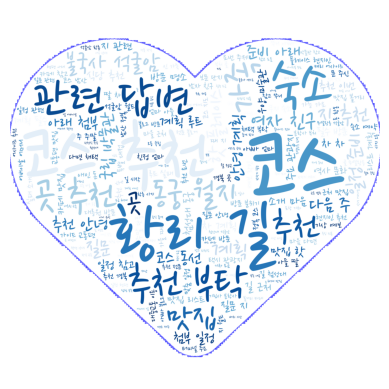

In [71]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
img = Image.open('data/heart.jpg')
mask = np.array(img)

wordcloud = WordCloud(
    font_path='data/NanumPenScript-Regular.ttf',
    background_color = 'white',
    colormap = 'Blues',
    collocations = True, #특정 단어가 자주 같이 나오면 같이 뿌리기
    max_words=200,
    scale = 2, #이미지 크기 비율(파일 저장시)
    mask=mask,
    contour_color = 'blue',
    contour_width=1
).generate(gj_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [72]:
# 생성된 wordcloud 저장
wordcloud.to_file('data/naver_경주.jpg')

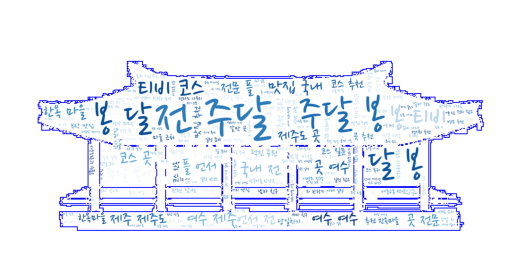

In [73]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
img = Image.open('data/korea-house-black-fill.png')
mask = np.array(img)

wordcloud = WordCloud(
    font_path='data/NanumPenScript-Regular.ttf',
    background_color = 'white',
    colormap = 'Blues',
    collocations = True, #특정 단어가 자주 같이 나오면 같이 뿌리기
    max_words=200,
    scale = 2, #이미지 크기 비율(파일 저장시)
    mask=mask,
    contour_color = 'blue',
    contour_width=1
).generate(jj_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [75]:
# 생성된 wordcloud 저장
wordcloud.to_file('data/naver_전주.jpg')

# 빈도수 시각화 (nltk.Text)

In [76]:
df_gj_noun_list = df_nouns.loc[df_nouns['query']=='경주 여행', 'token'].to_list()
df_jj_noun_list = df_nouns.loc[df_nouns['query']=='전주 여행', 'token'].to_list()

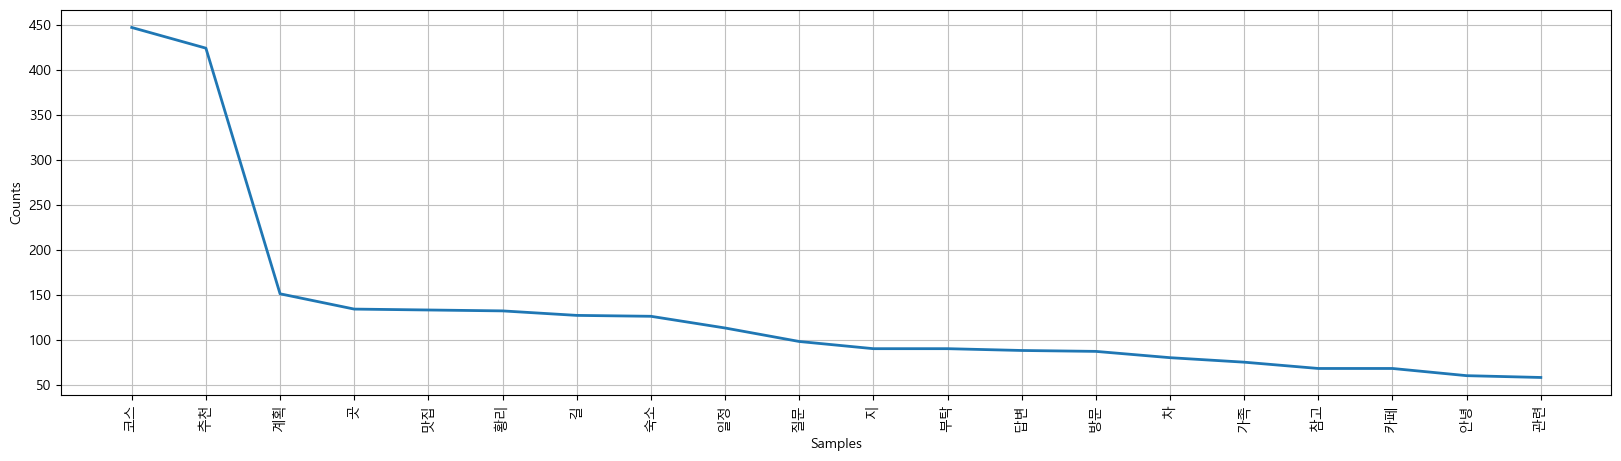

In [78]:
import nltk
data_text = nltk.Text(df_gj_noun_list)
plt.figure(figsize=(20,5))
plt.rc('font', family='Malgun Gothic')
data_text.plot(20)
plt.show()

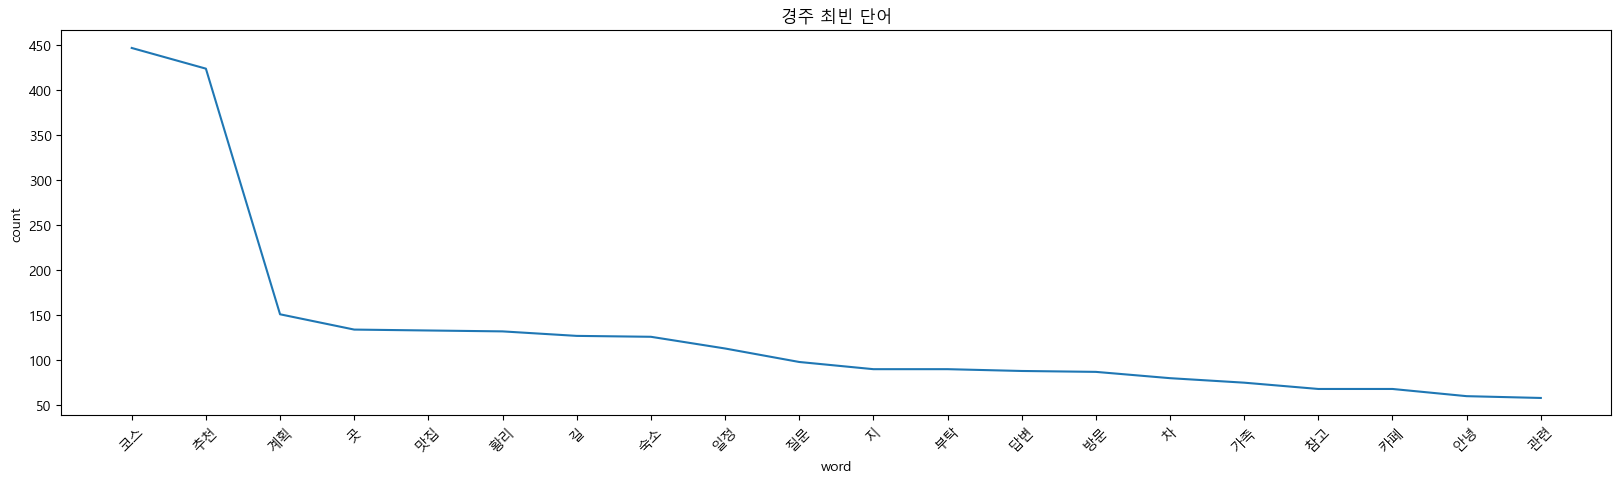

In [82]:
word, counts = zip(*data_text.vocab().most_common(20))

plt.figure(figsize=(20,5))
plt.plot(word, counts)
plt.xticks(rotation=45)
plt.xlabel('word')
plt.ylabel('count')
plt.title('경주 최빈 단어')
plt.show()

# 유사도 분류
## Word2Vec

In [83]:
df = pd.read_csv('data/naver.csv')
df.sample()

,query,no,title,link,description,total_text
743,경주 여행,244,2박3일 경주여행 코스 추천,https://kin.naver.com/qna/detail.naver?d1id=9&...,뚜벅이 위한 경주여행 코스 추천 부탁드려요 세분이 오붓하게 경주여행 계획하고 계시...,2박3일 경주여행 코스 추천 뚜벅이 위한 경주여행 코스 추천 부탁드려요 세분이 ...


In [86]:
total_text_list = df['total_text'].to_list()
total_text_list[:2]

['25년10월5,6,7일  전주여행   전주여행 가볼만한 곳 추천부탁드립니다 25년 10월 초 전주여행 아이들과 함께 가기 좋은 시점이에요 추석에는 문 연 곳이 적을 수 있지만 전주 한옥마을이나 전주비빔밥 맛집은 추천해용 차는 밀릴 가능성이 높으니 미리 출발하는 ',
 'KTX로 떠나는  전주 여행 , 주요 관광지 도보 이동...   전주 여행 계획 중이시군요 전주역에서 한옥마을까지는 사실 도보로는 좀 멀어요 약 3km 정도 되고 40분 정도 걸립니다 그래서 대부분 택시나 버스를 이용하시는데 택시는 10분 정도면 도착하고 요금도 7 8천원 정도로 부담 없어요 ']

In [89]:
from mecab import MeCab
select_pos = ['NNP',"NNG"]
불용어 = {'여행'}
analyzer = MeCab()
total_noun_list = []
for total_text in total_text_list:
    noun_list = [token for token, tag in analyzer.pos (total_text)
                if tag in select_pos and 
                token not in 불용어 and 
                len(token)>1]
    total_noun_list.append(noun_list)
print(total_noun_list[:2])

[['전주', '전주', '추천', '부탁', '전주', '아이', '시점', '추석', '전주', '한옥마을', '전주비빔밥', '맛집', '추천', '해용', '가능', '출발'], ['전주', '주요', '관광지', '도보', '이동', '전주', '계획', '주역', '한옥마을', '도보', '정도', '정도', '대부분', '택시', '버스', '이용', '택시', '정도', '도착', '요금', '정도', '부담']]


In [92]:
from gensim.models import Word2Vec
model = Word2Vec(total_noun_list, window=10, min_count=2, workers=-1,
                 sg=1)

In [94]:
model.wv.most_similar('전주')

[('식사', 0.35955357551574707),
 ('동선', 0.2897421419620514),
 ('리스트', 0.2753794491291046),
 ('덕진구', 0.27314674854278564),
 ('현재', 0.2580289840698242),
 ('가격', 0.22950327396392822),
 ('반려', 0.22023282945156097),
 ('답변', 0.21883946657180786),
 ('한옥마을', 0.21617145836353302),
 ('허락', 0.21353226900100708)]

In [96]:
model.wv.most_similar('경주')

[('호수', 0.36410051584243774),
 ('여름', 0.2186741977930069),
 ('배차', 0.2163221687078476),
 ('경기전', 0.21598941087722778),
 ('인근', 0.21469099819660187),
 ('황동', 0.2134207785129547),
 ('다랭이', 0.20914915204048157),
 ('봉길', 0.20906013250350952),
 ('남편', 0.2070489227771759),
 ('체계', 0.20607849955558777)]

# 연관분석


In [97]:
print(total_noun_list[:2])

[['전주', '전주', '추천', '부탁', '전주', '아이', '시점', '추석', '전주', '한옥마을', '전주비빔밥', '맛집', '추천', '해용', '가능', '출발'], ['전주', '주요', '관광지', '도보', '이동', '전주', '계획', '주역', '한옥마을', '도보', '정도', '정도', '대부분', '택시', '버스', '이용', '택시', '정도', '도착', '요금', '정도', '부담']]


In [103]:
%%time
from apyori import apriori
rules = apriori(total_noun_list, min_support=0.15, min_confidence=0.3, min_lift=1.01)
rules = list(rules)
len(rules)

CPU times: total: 15.6 ms
Wall time: 16.4 ms


125

In [105]:
import pandas as pd
rules_df = pd.DataFrame(None, columns=['lhs', 'rhs', '지지도','신뢰도', '향상도'])
idx = 0
for row in rules:
    support = row[1]
    ordered_st = row[2]
    for item in ordered_st:
        #print(item)
        lhs = item[0]
        lhs = ','.join([x for x in lhs])
        rhs = item[1]
        rhs = ','.join([x for x in rhs])
        confidence = item[2]
        lift = item[3]
        rules_df.loc[idx] = [lhs, rhs, support, confidence, lift]
        idx += 1
#         print("{:10}=>{:16}\t{}\t{}\t{:.2f}".format(lhs, rhs, support, 
#                                                 round(confidence, 2), 
#                                                 lift))
rules_df = rules_df.sort_values(by=['신뢰도', '향상도'], ascending=False)
rules_df.head(20)

,lhs,rhs,지지도,신뢰도,향상도
102,"국내,여수",티비,0.150,1.0,6.060606
132,"국내,주달",티비,0.155,1.0,6.060606
138,"국내,코스",티비,0.155,1.0,6.060606
162,"맛집,여수",티비,0.155,1.0,6.060606
228,"주달,여수",티비,0.155,1.0,6.060606
234,"여수,코스",티비,0.155,1.0,6.060606
307,"국내,여수","맛집,티비",0.150,1.0,6.060606
312,"국내,맛집,여수",티비,0.150,1.0,6.060606
377,"국내,주달","맛집,티비",0.155,1.0,6.060606
382,"국내,맛집,주달",티비,0.155,1.0,6.060606
